# Data Simulator

In [1]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal

np.random.seed(22)

def generate_fixed_effects(n, d=9, C=None):
    X = np.random.normal(0, 1, size=(n, d))
    Fx = 2 * X[:, 0] + X[:, 1]**2 + 4 * (X[:, 2] > 0) + 2 * np.log(np.abs(X[:, 0] * X[:, 2]))
    
    if C is None:
        C = 1 / np.std(Fx)
    
    F = C * Fx
    return F, X

def generate_grouped_random_effects(n, m, sigma1_squared=1):
    group_ids = np.random.choice(m, size=n)
    b = np.random.normal(0, np.sqrt(sigma1_squared), size=m)
    Zb = b[group_ids]
    return Zb, group_ids

def generate_spatial_gp(n, locations, sigma1_squared=1, rho=0.1):
    dists = cdist(locations, locations)
    covariance_matrix = sigma1_squared * np.exp(-dists / rho)
    
    Zb = multivariate_normal.rvs(mean=np.zeros(n), cov=covariance_matrix)
    return Zb

def generate_data(n, model_type="grouped", m=500, sigma1_squared=1, sigma_squared=1, rho=0.1, locations=None):
    F, X = generate_fixed_effects(n)
    if model_type == "grouped":
        Zb, group_ids = generate_grouped_random_effects(n, m, sigma1_squared)
        locations_or_groups = group_ids
    elif model_type == "spatial":
        if locations is None:
            raise ValueError("For spatial model, locations must be provided.")
        Zb = generate_spatial_gp(n, locations, sigma1_squared, rho)
        locations_or_groups = locations
    else:
        raise ValueError("Invalid model_type. Choose from 'grouped' or 'spatial'.")
    epsilon = np.random.normal(0, np.sqrt(sigma_squared), size=n)
    y = F + Zb + epsilon
    
    return y, X, Zb, epsilon, locations_or_groups

def generate_locations(n, area="train"):
    if area == "train" or area == "interpolation":
        # [0, 1]^2 \ [0.5, 1]^2
        locations = []
        while len(locations) < n:
            loc = np.random.uniform(0, 1, size=(n, 2))
            mask = (loc[:, 0] < 0.5) | (loc[:, 1] < 0.5)  # Exclude [0.5, 1]^2
            locations.extend(loc[mask])
        locations = np.array(locations[:n])
    elif area == "extrapolation":
        # [0.5, 1]^2
        locations = np.random.uniform(0.5, 1, size=(n, 2))
    else:
        raise ValueError("Invalid area. Choose from 'train', 'interpolation', or 'extrapolation'.")
    
    return locations

def generate_train_test_data(n_train, n_test, model_type, m=500, sigma1_squared=1, sigma_squared=1, rho=0.1):
    if model_type == "spatial":
        train_locations = generate_locations(n_train, area="train")
        interp_locations = generate_locations(n_test, area="interpolation")
        extrap_locations = generate_locations(n_test, area="extrapolation")
        
        train_data = generate_data(n_train, model_type, 
                                   sigma1_squared=sigma1_squared, 
                                   sigma_squared=sigma_squared, rho=rho, 
                                   locations=train_locations)
        test_data_interpolation = generate_data(n_test, model_type, 
                                                sigma1_squared=sigma1_squared, 
                                                sigma_squared=sigma_squared, 
                                                rho=rho, locations=interp_locations)
        test_data_extrapolation = generate_data(n_test, model_type, 
                                                sigma1_squared=sigma1_squared, 
                                                sigma_squared=sigma_squared, 
                                                rho=rho, locations=extrap_locations)
    else:
        train_data = generate_data(n_train, model_type, m=m, 
                                   sigma1_squared=sigma1_squared, 
                                   sigma_squared=sigma_squared)
        test_data_interpolation = generate_data(n_test, model_type, m=m, 
                                                sigma1_squared=sigma1_squared, 
                                                sigma_squared=sigma_squared)
        test_data_extrapolation = generate_data(n_test, model_type, m=m, 
                                                sigma1_squared=sigma1_squared, 
                                                sigma_squared=sigma_squared)
    
    return train_data, test_data_interpolation, test_data_extrapolation

n_train = 500
n_test = 500

train_spatial, test_interp_spatial, test_extrap_spatial = generate_train_test_data(
    n_train, n_test, model_type="spatial", sigma1_squared=1, sigma_squared=1, rho=0.1
)


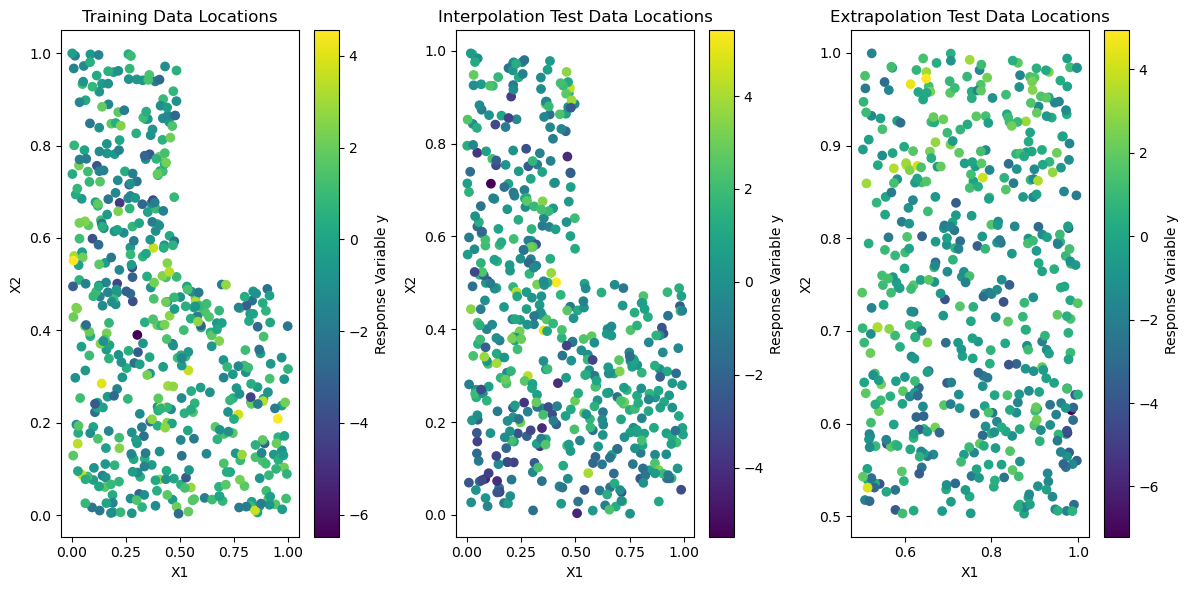

In [2]:
import matplotlib.pyplot as plt

train_locations = train_spatial[4]
train_y = train_spatial[0]

interp_locations = test_interp_spatial[4]
interp_y = test_interp_spatial[0]

extrap_locations = test_extrap_spatial[4]
extrap_y = test_extrap_spatial[0]

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.scatter(train_locations[:, 0], train_locations[:, 1], c=train_y, cmap='viridis', marker='o')
plt.colorbar(label='Response Variable y')
plt.title('Training Data Locations')
plt.xlabel('X1')
plt.ylabel('X2')

plt.subplot(1, 3, 2)
plt.scatter(interp_locations[:, 0], interp_locations[:, 1], c=interp_y, cmap='viridis', marker='o')
plt.colorbar(label='Response Variable y')
plt.title('Interpolation Test Data Locations')
plt.xlabel('X1')
plt.ylabel('X2')

plt.subplot(1, 3, 3)
plt.scatter(extrap_locations[:, 0], extrap_locations[:, 1], c=extrap_y, cmap='viridis', marker='o')
plt.colorbar(label='Response Variable y')
plt.title('Extrapolation Test Data Locations')
plt.xlabel('X1')
plt.ylabel('X2')

plt.tight_layout()
plt.show()

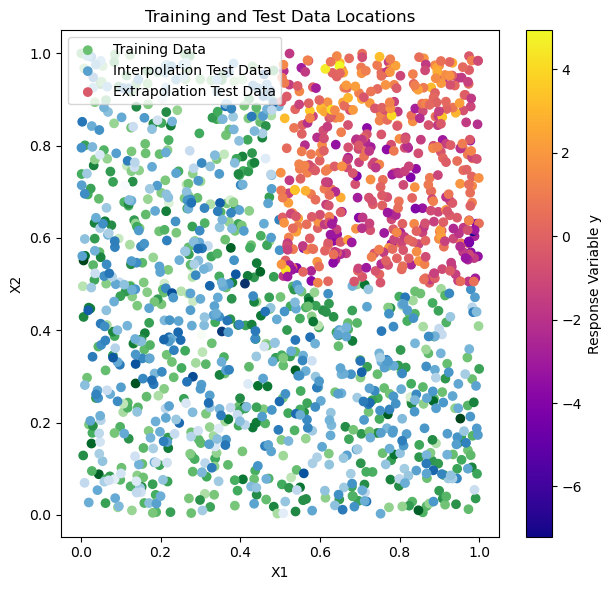

In [3]:
import matplotlib.pyplot as plt

train_locations = train_spatial[4]
train_y = train_spatial[0]

interp_locations = test_interp_spatial[4]
interp_y = test_interp_spatial[0]

extrap_locations = test_extrap_spatial[4]
extrap_y = test_extrap_spatial[0]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(train_locations[:, 0], train_locations[:, 1], c=train_y, cmap='Greens', marker='o', label='Training Data')
plt.scatter(interp_locations[:, 0], interp_locations[:, 1], c=interp_y, cmap='Blues', marker='o', label='Interpolation Test Data')
plt.scatter(extrap_locations[:, 0], extrap_locations[:, 1], c=extrap_y, cmap='plasma', marker='o', label='Extrapolation Test Data')
plt.colorbar(label='Response Variable y')
plt.title('Training and Test Data Locations')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.tight_layout()
plt.show()

# GPBoost

In [4]:
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from sklearn.base import clone
import numpy as np

class GPBoost:
    def __init__(self, learning_rate=0.1, n_iterations=100, boost_type="gradient", 
                 nesterov_accel=False, momentum_sequence=None):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.boost_type = boost_type
        self.nesterov_accel = nesterov_accel
        self.momentum_sequence = momentum_sequence or [0.5] * n_iterations
        self.base_learners = []

    def loss_function(self, y, F, theta, Sigma):
        residual = y - F
        Sigma += np.eye(Sigma.shape[0]) * 1e-6
        return 0.5 * residual.T @ np.linalg.solve(Sigma, residual) + \
               0.5 * np.log(np.linalg.det(Sigma)) + len(y) * 0.5 * np.log(2 * np.pi)

    def optimize_theta(self, y, F, theta_init, Sigma_func, bounds):
        def objective(theta):
            Sigma = Sigma_func(theta)
            return self.loss_function(y, F, theta, Sigma)
        result = minimize(objective, theta_init, method='L-BFGS-B', bounds=bounds)
        return result.x

    def fit(self, X, y, initial_theta, Sigma_func, base_learner):
        n_samples = len(y)
        theta = initial_theta
        self.F0 = np.mean(y)
        F = np.full(n_samples, self.F0)
        G_prev = None

        self.X_train = X
        self.y_train = y
        self.Sigma_func = Sigma_func

        for m in range(self.n_iterations):
            bounds = [(1e-5, None)] * len(theta)
            theta = self.optimize_theta(y, F, theta, Sigma_func, bounds)
            Sigma = Sigma_func(theta)

            if self.nesterov_accel:
                G_curr = F.copy()
                if m > 0:
                    F += self.momentum_sequence[m] * (G_curr - G_prev)
                G_prev = G_curr

            residual = y - F
            learner_m = clone(base_learner)
            if self.boost_type == "gradient":
                gradient = np.linalg.solve(Sigma, residual)
                learner_m.fit(X, gradient)
            elif self.boost_type == "newton":
                learner_m.fit(X, residual)
            elif self.boost_type == "hybrid":
                gradient = np.linalg.solve(Sigma, residual)
                hessian_diag = np.diag(np.linalg.inv(Sigma)).copy()
                hessian_diag[hessian_diag == 0] = 1e-6
                modified_gradient = gradient / hessian_diag
                learner_m.fit(X, modified_gradient)
            
            F += self.learning_rate * learner_m.predict(X)
            self.base_learners.append(learner_m)

        self.theta = theta

    def covariance_between_train_test(self, theta, X_train, X_new):
        sigma1_squared, rho = theta
        dists = cdist(X_train, X_new)
        return sigma1_squared * np.exp(-dists / rho)

    def covariance_matrix(self, theta, X):
        sigma1_squared, rho = theta
        dists = cdist(X, X)
        return sigma1_squared * np.exp(-dists / rho) + np.eye(len(X)) * 1e-6

    def predict(self, X_new, base_learner):
        F_fixed = np.full(X_new.shape[0], self.F0)
        for learner in self.base_learners:
            F_fixed += self.learning_rate * learner.predict(X_new)

        F_fixed_train = np.full(len(self.y_train), self.F0)
        for learner in self.base_learners:
            F_fixed_train += self.learning_rate * learner.predict(self.X_train)

        residuals = self.y_train - F_fixed_train
        K_train = self.Sigma_func(self.theta)
        K_s = self.covariance_between_train_test(self.theta, self.X_train, X_new)
        K_ss = self.covariance_matrix(self.theta, X_new)
        noise_variance = 1e-6
        K_train += np.eye(len(self.y_train)) * noise_variance

        K_inv = np.linalg.inv(K_train)
        F_random = K_s.T @ K_inv @ residuals

        return F_fixed + F_random


In [5]:
import warnings
warnings.filterwarnings('ignore')

GPBoost_Int: 2.437667331811853
LightGBM_Int: 2.5347995221862134
CatBoost_Int: 2.4737651808262293
GPBoost_Ext: 2.1895537372500566
LightGBM_Ext: 2.2453824465707513
CatBoost_Ext: 2.2705155916410087


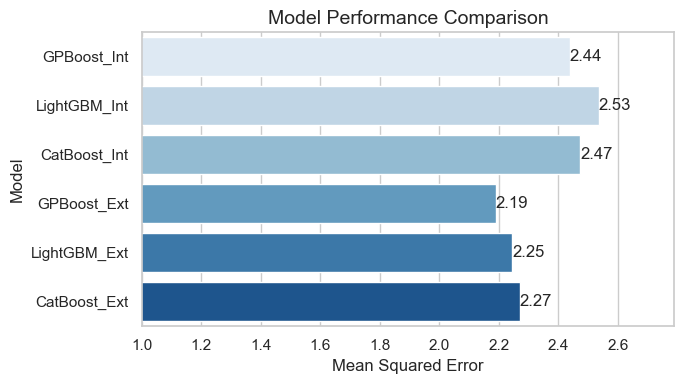

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import copy
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
import statsmodels.api as sm

def Sigma_func_spatial(theta, locations):
    sigma1_squared, rho = theta
    dists = cdist(locations, locations)
    return sigma1_squared * np.exp(-dists / rho) + np.eye(len(locations)) * 1e-6

def train_gpboost(X_train, y_train, initial_theta, Sigma_func, base_learner):
    gpboost = GPBoost(learning_rate=0.05, n_iterations=50, boost_type="hybrid")
    gpboost.fit(X_train, y_train, initial_theta, Sigma_func, base_learner)
    return gpboost

def predict_gpboost(gpboost, X_test, base_learner):
    return gpboost.predict(X_test, base_learner)

def train_lightgbm(X_train, y_train):
    train_data_lgb = lgb.Dataset(X_train, label=y_train)
    params = {
        'objective': 'regression',
        'metric': 'mse',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'verbose': -1,
    }
    lgb_model = lgb.train(params, train_data_lgb, num_boost_round=50)
    return lgb_model

def predict_lightgbm(lgb_model, X_test):
    return lgb_model.predict(X_test)

def train_catboost(X_train, y_train):
    cat_model = CatBoostRegressor(iterations=50, learning_rate=0.05, depth=3, verbose=0)
    cat_model.fit(X_train, y_train)
    return cat_model

def predict_catboost(cat_model, X_test):
    return cat_model.predict(X_test)


def plot_mse_comparison(mse_results):
    plt.figure(figsize=(7, 4))
    
    model_names = list(mse_results.keys())
    mse_values = list(mse_results.values())

    mse_df = pd.DataFrame({
        'Model': model_names,
        'MSE': mse_values
    })

    sns.set_theme(style="whitegrid")
    bar_plot = sns.barplot(x='MSE', y='Model', data=mse_df, palette='Blues')
    for index, value in enumerate(mse_values):
        bar_plot.text(value, index, f'{value:.2f}', va='center')

    plt.xlabel('Mean Squared Error')
    plt.title('Model Performance Comparison', fontsize=14)
    plt.xlim(1, max(mse_values) * 1.1)
    plt.tight_layout()
    plt.show()

    
def compare_models(n_train=500, n_test=500):
    train_spatial, test_interp_spatial, test_extrap_spatial = generate_train_test_data(
        n_train, n_test, model_type="spatial", sigma1_squared=1, sigma_squared=1, rho=0.1
    )
    y_train, X_train, Zb_train, epsilon_train, train_locations = train_spatial
    y_test_interp, X_test_interp, Zb_test_interp, epsilon_test_interp, interp_locations = test_interp_spatial
    y_test_extrap, X_test_extrap, Zb_test_extrap, epsilon_test_extrap, extrap_locations = test_extrap_spatial

    initial_theta = np.array([1.0, 0.01])

    base_learner = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10)
    gpboost = train_gpboost(X_train, y_train, initial_theta, lambda theta: Sigma_func_spatial(theta, train_locations), base_learner)
    predictions_gpboost_interp = predict_gpboost(gpboost, X_test_interp, base_learner)
    predictions_gpboost_extrap = predict_gpboost(gpboost, X_test_extrap, base_learner)

    lgb_model = train_lightgbm(X_train, y_train)
    predictions_lgb_interp = predict_lightgbm(lgb_model, X_test_interp)
    predictions_lgb_extrap = predict_lightgbm(lgb_model, X_test_extrap)

    cat_model = train_catboost(X_train, y_train)
    predictions_cat_interp = predict_catboost(cat_model, X_test_interp)
    predictions_cat_extrap = predict_catboost(cat_model, X_test_extrap)

    mse_results = {
        "GPBoost_Int": mean_squared_error(y_test_interp, predictions_gpboost_interp),
        "LightGBM_Int": mean_squared_error(y_test_interp, predictions_lgb_interp),
        "CatBoost_Int": mean_squared_error(y_test_interp, predictions_cat_interp),
        "GPBoost_Ext": mean_squared_error(y_test_extrap, predictions_gpboost_extrap),
        "LightGBM_Ext": mean_squared_error(y_test_extrap, predictions_lgb_extrap),
        "CatBoost_Ext": mean_squared_error(y_test_extrap, predictions_cat_extrap),
    }

    for model_name in mse_results:
        print(f"{model_name}: {mse_results[model_name]}")

    plot_mse_comparison(mse_results)

compare_models()